#                                   Description Triangle Algorithm                                   #
                                        
####################### each crownstone #######################                           

1a: Check all connections in area in certain range of RSSI \
1b: Communicate with neighbours, request RSSI and update the vertices in the formed array/table \
#-------------------> Array format: cX/cY/RSSI \

2: sort the list of vertices. at the top his own vertices in order of RSSI value \
3: start at the top of the list, take a = list(i) and b = list(i+1) / two best connections, for example: c1/c2/-45 and c1/c3/-47 \
4a: send message to both Crownstones, in this example c2 and c3, to ask for their vertices / specific vertices between two known crownstones \
4b If there is a node/vertice match, make a triangle with pointers to the vertices array/table \
#-------------------> Array format: p1/p2/p3 \
5: If not, take b = list(i++), maximum check = 5?, still not found? discard, a = list(i++), and continue at #3: \

####################### Communication ####################### 
                                        
Between two Crownstones: \
1: Request: check his connections on a specific Crownstone \
<->  \
2: Answer: specific Crownstone connection values in format: cX(already known)/cY/RSSI \

Mesh message between all Crownstones:\ 
1: Global request for exchange of triangles to Hub \
2: Every Cronwstone sends its best triangles (max 3-5) \

####################### Processing/Mapping ####################### 

All triangles will be send to the hub. The hub will further process the triangles to a map.


In [1]:
# Run once to install all packages needed
# %pip install ipympl, matplotlib, networkx, pandas, numpy 

In [2]:
%matplotlib widget

import random
from random import normalvariate
import math
from math import sqrt, log10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import networkx as nx
from IPython.display import display, clear_output
import ipywidgets as widgets
from collections import Counter

In [3]:
#-----------------------------------------#

random.seed(7)
num_nodes = 5

#-----------------------------------------#

In [4]:
def compareGraph3D(Network_Dict, RefNode_List):
    G = nx.Graph()

    i = 0
    for nodeID, edges in Network_Dict.items():
        G.add_node(nodeID, pos=RefNode_List[i])
        for edge in edges:
            G.add_edge(edge.src.uuid, edge.dst.uuid, Rssi=edge.rssi)
        i += 1

    pos = nx.get_node_attributes(G, 'pos')
    rssi = nx.get_edge_attributes(G, "Rssi")

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

    # Draw nodes as scatter plot and text labels
    for nodeID, coords in pos.items():
        ax.scatter(*coords, c="blue", s=100, marker='o')
        ax.text(*coords, f'Node {nodeID}\n({coords[0]}, {coords[1]}, {coords[2]})', ha='center', va='bottom')

    # Draw edges in 3D
    for edge in G.edges():
        xs, ys, zs = zip(*[pos[edge[i]] for i in range(2)])
        ax.plot(xs, ys, zs, color='black')
        rssi_value = rssi.get(edge, "")
        ax.text(sum(xs)/2,sum(ys)/2,sum(zs)/2, f"{rssi_value}", color='red')

    ax.set_title("Node plot with signal strength (RSSI) (3D)")
    plt.show()

def distance_to_rssi(nodeCoord1, nodeCoord2):
    c1x, c1y, c1z = nodeCoord1
    c2x, c2y, c2z = nodeCoord2
    distance = math.sqrt((c1x-c2x)**2 + (c1y-c2y)**2 + (c1z-c2z)**2)
    # noise = normalvariate(0, sqrt(20))
    noise = 0
    rssi = -70 - 10 * 2.0 * log10(distance) + noise
    # return round(distance, 3)
    return round(rssi, 3)


# log function or later try neural net conversion
def rssi_to_distance(rssi):
    return round(10**((-rssi-70)/(20)),3)

In [5]:
# Node class, which represents a individual Crownstone
class Node:

    def __init__(self, HWuuid: str):
        self.uuid = HWuuid
        self.coord = (0,0,0)
        self.SurNodes = set() # set with (node reference, rssi)
        self.edgeList = []
        self.triangleList = []
        self.adjTrianglesDict = {}

    def __str__(self) -> str:
        return f"Node (Uuid= {self.uuid}, Coord= {self.coord})"
    
    def __repr__(self):
        return str(self)
    
    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edgeList))
        triangles_str = ', '.join(map(str, self.triangleList))
        nodes_str = ', '.join(map(str, [node.uuid for node, rssi in self.SurNodes])) 
        return f"Node uuid={self.uuid}:{self.coord} [:] Surrounding Nodes= {nodes_str}, Edgelist= {edges_str}, TriangleList={triangles_str} [:]"
      
    def compare(self, other: object):
        return self.uuid == other.uuid
    
    # Initial scan for surrounding nodes in the environment 
    def scanSurroundings(self, network_edges):
        for edge in network_edges[self.uuid]:
            self.SurNodes.add((edge.dst,edge.rssi))
        self.SurNodes = sorted(self.SurNodes, key=lambda x: x[1], reverse=True)

    # Node search request for target
    def requestNodeSearch(self, target, searched_Node):
        # send BLE message to target and wait for response
        found = target.checkSurNode(searched_Node)
        if (found == False):
            print("Node NOT visible")
        else:
            return found # (Node, RSSI)

    # NodeSearch response, checks if requested node is visible in surroundings
    def nodeSearch(self, checkFor: object) -> tuple:
        for surNode in self.SurNodes:
            if surNode[0] == checkFor:
                return surNode
        return False
    
    # Checks if EndNode is in current list of edges
    def checkEdge(self, EndNode):
        for edge in self.edgeList:
            if edge.dst == EndNode:
                return edge
        return False

    # Test function, will be reformed, or moved to main/organizer function
    def createEdgeWith(self, other: object):
        selfCheck = self.checkSurNode(other)
        otherCheck = other.checkSurNode(self) # ask other side if it can see you
        if (otherCheck != False) and (selfCheck[1] == otherCheck[1]):
            self.edgeList.append(Edge(self, other, selfCheck[1]))
            self.edgeList.sort(key=lambda x: x.rssi, reverse=True)
            # self.edgeList = [edge for edge in self.edgeList if edge.rssi < -85]
            return True
        print("Node not visible\n")
        return False
    
    # Check if triangle is already added to internal trianglelist
    def checkTriangle(self, checkTriangle):
        for triangle in self.triangleList:
            if triangle == checkTriangle:
                return True
        return False
    
     # Triangle search request for target
    def requestTriangleSearch(self, target_Node, searched_Edge):
        # send BLE message to target and wait for response
        found = target_Node.triangleSearch(searched_Edge)
        if (found == False):
            print(f"Triangle does NOT exist at {target_Node.uuid}")
        return found
    
    # Internal triangle/opposite_edge search in all triangles of the trianglelist
    def triangleSearch(self, opposite_edge):
        for triangle in self.triangleList:
            if triangle.hasEdge(opposite_edge):
                return triangle
        return False        

    # Make a new triangle from the supplied edges and add it to the trianglist if it does not exist already
    def addTriangle(self, edge1,edge2,edge3):
        temp = Triangle(edge1,edge2,edge3)
        # check if triangle not already exist
        if self.checkTriangle(temp) == False:
            self.triangleList.append(temp)
        else:
            print("Duplicate!")

    # Test function, will be reformed, or moved to main/organizer function
    def createTriangleWith(self, dst1: object, dst2: object):
        if not self.compare(dst1) and not self.compare(dst2):
            # ask ab and ac if they have bc
            common_edge1 = dst1.checkEdge(dst2)
            common_edge2 = dst2.checkEdge(dst1)
            if common_edge1 == False or common_edge2 == False:
                return False
            # if true form a triangle
            if common_edge1.compare(common_edge2):
                # Triangle(best edge, second best edge, opposite edge) 
                self.addTriangle(self.checkEdge(dst1), self.checkEdge(dst2), common_edge1)
                return True
        print("Triangle not possible")
        return False
    
    # Test function, will be reformed, or moved to main/organizer function
    def createAllTriangles(self):
        sur_nodes_list = list(self.SurNodes)
        sur_nodes_count = len(sur_nodes_list)
        for i in range(sur_nodes_count):
            for j in range(i + 1, sur_nodes_count):
                node1, _ = sur_nodes_list[i]
                node2, _ = sur_nodes_list[j]
                self.createTriangleWith(node1, node2)

    # !!!!!!! THIS PART NEEDS MORE ATTENTION !!!!!!!
    # This procedure will walk all the nodes and will make N triangles. routine: iterate surnodes, make edge from first, add them to edgelist, 
    # check if edge sees other nodes, compare with surNodes, if True, form edges and make triangle
    def triangleProcedure(self):
        # sur_nodes_list = list(self.SurNodes)
        # sur_nodes_count = len(sur_nodes_list)
        # for i in range(sur_nodes_count):
        # for j in range(i + 1, sur_nodes_count):
        # node1, _ = sur_nodes_list[i]
        # node2, _ = sur_nodes_list[j]
        # self.createTriangleWith(node1, node2)

        # selfCheck = self.checkSurNode(other)
        # otherCheck = other.checkSurNode(self) # ask other side if it can see you
        # if (otherCheck != False) and (selfCheck[1] == otherCheck[1]):
        # self.edgeList.append(Edge(self, other, selfCheck[1]))
        # self.edgeList.sort(key=lambda x: x.rssi, reverse=True)
        # # self.edgeList = [edge for edge in self.edgeList if edge.rssi < -85]
        # return True
        # print("Node not visible\n")
        # return False

        # if not self.compare(dst1) and not self.compare(dst2):
        # # ask ab and ac if they have bc
        # common_edge1 = dst1.checkEdge(dst2)
        # common_edge2 = dst2.checkEdge(dst1)
        # if common_edge1 == False or common_edge2 == False:
        # return False
        # # if true form a triangle
        # if common_edge1.compare(common_edge2):
        # # Triangle(best edge, second best edge, opposite edge) 
        # self.addTriangle(self.checkEdge(dst1), self.checkEdge(dst2), common_edge1)
        # return True
        # print("Triangle not possible")
        return False
    
    # Links all triangles from trianglelist to individual edges from the edgelist, so edge(AB) has adj
    def createAdjTriangles(self):
        if len(self.edgeList) == 0 or len(self.triangleList) == 0:
            print("NO edges or triangles")
            return False 
        
        triangle_dict = {}
        for base_edge in self.edgeList:
            for triangle in self.triangleList:
                if triangle.hasEdge(base_edge):
                    adjTriangle = Adjacent(triangle)
                    if base_edge not in triangle_dict:
                        adjTriangle.setCoord((base_edge.dst.uuid,base_edge.dist))
                        triangle_dict[base_edge] = [adjTriangle]
                    else:
                        triangle_dict[base_edge].append(adjTriangle)          
        self.adjTrianglesDict = triangle_dict
    
    # Prints the adjacent triangle dict, all adj triangle per edge from self perspective
    def printAdjDict(self):
        print()
        if len(self.adjTrianglesDict) == 0:
            print("No adj triangles dict")
            return
        
        print(f"Adjacent triangles of {self.uuid}:") 
        for edge, adj_list in self.adjTrianglesDict.items():
            print(f"Edge {edge.id}:")
            for adj in adj_list:
                print(adj)
        print()
    
    # Checks if edge between two adjacent triangles exists and return the angle, for example: ABC and ABD, check for edge CD -> search triangle ACD or 
    def mapAngle(self, defaultOtherNode, otherNode):
        opposite_edge = Edge(defaultOtherNode,otherNode,0)
        tempTri = self.searchTriangle(opposite_edge) # first check internal
        if tempTri == False:
            print(f"No internal triangle with {opposite_edge.id} found!")
            # make new temp triangle Traingle() with Edge(self,edge.src,rssi) and Edge(self,edge.dst,rssi) and oppostite_edge and return Triangle().angle
            return None
        else:
            return tempTri.angle
        
    # Requests altitude position and height from the askNode, for example: you are A in triangle ABC, base_edge AB, askNode C, check if it has triangle with the values for altitude information 
    def mapAltiRequest(self, askNode, base_edge):
        tempTri = self.requestTriangleSearch(askNode, base_edge)
        if tempTri == False:
            print('Error retrieving altitude information')
            return False, False
        else:    
            return tempTri.altiX, tempTri.altiH
    
    # Iterates on the adjacent triangles, set the first on XY/default and do cal, and calculate for the following triangles the angle between default, altiX, altiH 
    def mapAdjacents(self):
        for base_edge, adj_list in self.adjTrianglesDict.items():
           
            altiX, altiH = self.getMapAltiFrom(adj_list[0].triangle.getLastNode(base_edge),base_edge)
            if altiX != False:
                adj_list[0].setAltiH(altiH)
                adj_list[0].setAltiX(altiX)

            if len(adj_list) > 1:
                defaultOtherNode = adj_list[0].triangle.getLastNode(base_edge)
                for i in range(1,len(adj_list)):
                    otherNode = adj_list[i].triangle.getLastNode(base_edge)
                    adj_list[i].setAngle(self.getMapAngle(defaultOtherNode,otherNode))

                    altiX, altiH = self.getMapAltiFrom(adj_list[i].triangle.getLastNode(base_edge),base_edge)
                    if altiX != False:
                        adj_list[i].setAltiH(altiH)
                        adj_list[i].setAltiX(altiX)

    def main(self, networkedges):
        # self.scanSurroundings(networkedges) for testing this is done manualy in main

        # should only be called after every node is done forming triangles! due to checkedge of triangle for altitude
        self.createAdjTriangles()
        self.mapAdjacents()
        self.printAdjDict()

       

class Edge:

    def __init__(self, src: Node, dst: Node, rssi):
        self.id = (src.uuid,dst.uuid)
        self.src = src
        self.dst = dst
        self.rssi = rssi
        self.dist = rssi_to_distance(rssi)

    def __str__(self) -> str:
        return f"({self.src.uuid},{self.dst.uuid},{self.dist:.3f})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(self.id)
    
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    def compare(self, other: object):
        self_src_uuid, self_dst_uuid = self.src.uuid, self.dst.uuid
        other_src_uuid, other_dst_uuid = other.src.uuid, other.dst.uuid

        return ((self_src_uuid == other_src_uuid and self_dst_uuid == other_dst_uuid) or
            (self_src_uuid == other_dst_uuid and self_dst_uuid == other_src_uuid)
        )

# triangles are stored locally and node specific, iow: edge are in the orientation of the node, ab, ac, bc
class Triangle:

    def __init__(self, edge1: Edge, edge2: Edge, edge3: Edge):
        self.edges = [edge1,edge2,edge3]
        self.weight = round(sum(edge.rssi for edge in self.edges), 3)
        self.nodes = [edge1.src, edge3.src, edge3.dst] # startnode|opposite edge src node|opposite edge dst node
        self.unique = sorted(set(node.uuid for node in self.nodes))
        self.ID = "|".join(map(str, self.unique))

        self.angle = self.getAngle()
        self.altiH = self.getAltitudeH()
        self.altiX = self.getAltitudeX()

    def __str__(self) -> str:
        edges_str = ', '.join(map(str, self.edges))
        return f"Triangle {self.ID}: Weight= {self.weight:.3f}, Edges= {edges_str}, Angles= {self.angle}, Altitude= (x={self.altiX}, H={self.altiH})"
    
    def __repr__(self):
        return str(self)
    
    def __hash__(self) -> int:
        return hash(f'{self.unique}')
      
    def __eq__(self, other: object) -> bool:
        return self.__hash__() == other.__hash__()
    
    # Checks if triangle has the edge_to_check in its edges
    def hasEdge(self, edge_to_check: Edge):
        for i, edge in enumerate(self.edges):
            if edge.compare(edge_to_check):
                return True
        return False

    # Returns the last node spanning the triangle, based on the base_edge src and dst node
    def getLastNode(self, base_edge: Edge):
        for node in self.nodes:
            if node != base_edge.src and node != base_edge.dst:
                return node         

    # Calculates the angle of the triangle from the node perspective corner     
    def getAngle(self): # ab0 ac1 bc2
        a = self.edges[2].dist # edge bc  
        b = self.edges[1].dist # edge ac  
        c = self.edges[0].dist # edge ab
        angle = np.rad2deg(np.arccos((b**2+c**2-a**2)/(2*b*c)))
        return (self.edges[0].src.uuid, round(angle,3))

    # Calculates the altitude height of the triangle from node perspective with Heron's formula 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude height is from corner A to side bc   
    def getAltitudeH(self): # ab0 ac1 bc2
        a = self.edges[0].dist # adjacent edge ab 
        b = self.edges[2].dist # opposite edge bc
        c = self.edges[1].dist # adjacent edge ac
        # Heron's formula 
        s = (a+b+c)/2
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        height = (2*area)/b
        return (self.edges[0].src.uuid, round(height,3))
    
    # def getAltitudeX(self): # ab0 ac1 bc2
    #     a = self.edges[0].dist # adjacent edge ab 
    #     b = self.edges[2].dist # opposite edge bc
    #     c = self.edges[1].dist # adjacent edge ac
    #     # Pythagoras formula
    #     xpos = (b**2 + c**2 - a**2) / (2 * b)
    #     return (self.edges[0].src.uuid, round(xpos,3))
    
    # Calculates the altitude X position with pythogoras from the node perspective corner onto the opposite edge. 
    # for example: self = A, ABC got edge ab,ac,bc -> altitude x position is from corner A (0,0,0) to altitude and edge intersection (x,0,0)   
    def getAltitudeX(self): # ab0 ac1 bc2
        ab = self.edges[0].dist 
        h = self.altiH[1]
        # Pythagoras formula
        xpos = math.sqrt((ab**2-h**2))
        return (self.edges[0].src.uuid, round(xpos,3))
    

class Adjacent:

    def __init__(self, triangle: Triangle):
        self.triangle = triangle
        self.angle = 0
        self.otherCoord = (None,None)
        self.altiX = None
        self.altiH = None

    def __str__(self) -> str:
        return f"Triangle({self.triangle.ID}): x-coord= {self.otherCoord}, map angle= {self.angle} | xpos altitude= {self.altiX} | altitude height= {self.altiH}"
    
    def __repr__(self):
        return str(self)
    
    def setCoord(self, coord):
        self.otherCoord = coord
    
    def setAngle(self, angle):
        self.angle = angle

    def setAltiX(self, xpos):
        self.altiX = xpos
    
    def setAltiH(self, height):
        self.altiH = height

<h1> Setup: Make n nodes and create edge list that represents the current network </h1>

In [6]:
def printNodes(node_List):
    print("List of nodes:")
    for node in node_List:
        print(node)
    print()

List of nodes:
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= , TriangleList= [:]
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= , TriangleList= [:]
Node uuid=C:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= , TriangleList= [:]
Node uuid=D:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= , TriangleList= [:]
Node uuid=E:(0, 0, 0) [:] Surrounding Nodes= , Edgelist= , TriangleList= [:]

Reference Network Edges:
Node A:= Edges[(A,E,3.162), (A,D,5.099), (A,B,6.325), (A,C,7.616)]
Node B:= Edges[(B,C,5.831), (B,D,5.831), (B,A,6.325), (B,E,7.071)]
Node C:= Edges[(C,D,2.828), (C,E,5.657), (C,B,5.831), (C,A,7.616)]
Node D:= Edges[(D,C,2.828), (D,E,2.828), (D,A,5.099), (D,B,5.831)]
Node E:= Edges[(E,D,2.828), (E,A,3.162), (E,C,5.657), (E,B,7.071)]


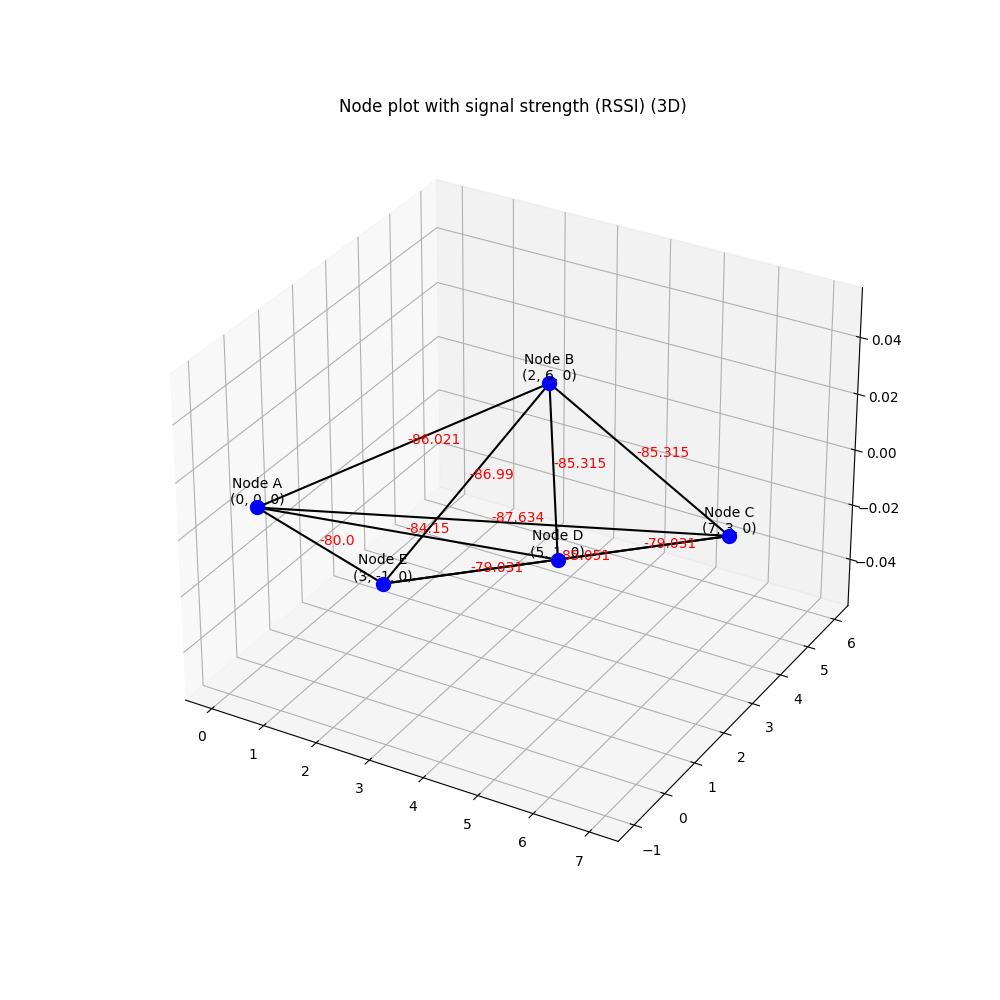

In [7]:
nodeList = []
RefNodeCoords = [(0,0,0),(2,6,0),(7,3,0),(5,1,0),(3,-1,0)]

names = list(map(chr,range(ord('A'),ord('Z')+1)))

for i in range(num_nodes): 
    nodeList.append(Node(names[i]))

printNodes(nodeList)

NetworkEdges = {}
for i in range(len(nodeList)):
    table = []
    for j in range(len(nodeList)):
        if nodeList[i] != nodeList[j]:
            table.append(Edge(nodeList[i], nodeList[j], distance_to_rssi(RefNodeCoords[i],RefNodeCoords[j])))
    table = sorted(table, key=lambda x: x.rssi, reverse=True)
    NetworkEdges[nodeList[i].uuid] = table

print('Reference Network Edges:')
for key, edges in NetworkEdges.items():
    print(f'Node {key}:= Edges{edges}')

compareGraph3D(NetworkEdges,RefNodeCoords)

<h1> Part 1: Start in Node A, check surrounding nodes, form edges </h1>

In [8]:
nodeA = nodeList[0]
nodeB = nodeList[1]
nodeC = nodeList[2]
nodeD = nodeList[3]
nodeE = nodeList[4]

# activate nodes, print function in parallel with Threading

nodeA.scanSurroundings(NetworkEdges)
nodeB.scanSurroundings(NetworkEdges)
nodeC.scanSurroundings(NetworkEdges)
nodeD.scanSurroundings(NetworkEdges)
nodeE.scanSurroundings(NetworkEdges)

printNodes(nodeList)

nodeA.main(NetworkEdges)
nodeB.main(NetworkEdges)
nodeC.main(NetworkEdges)
nodeD.main(NetworkEdges)
nodeE.main(NetworkEdges)

printNodes(nodeList)

List of nodes:
Node uuid=A:(0, 0, 0) [:] Surrounding Nodes= E, D, B, C, Edgelist= , TriangleList= [:]
Node uuid=B:(0, 0, 0) [:] Surrounding Nodes= C, D, A, E, Edgelist= , TriangleList= [:]
Node uuid=C:(0, 0, 0) [:] Surrounding Nodes= D, E, B, A, Edgelist= , TriangleList= [:]
Node uuid=D:(0, 0, 0) [:] Surrounding Nodes= E, C, A, B, Edgelist= , TriangleList= [:]
Node uuid=E:(0, 0, 0) [:] Surrounding Nodes= D, A, C, B, Edgelist= , TriangleList= [:]



AttributeError: 'Node' object has no attribute 'createAllEdges'